In [12]:
import numpy as np
import matplotlib.pyplot as plt
import jax

import icomo
from tapm import utils

In [46]:
def model(t, y, args):
    cm = icomo.CompModel(y)

    (prep_shortage, args) = args

    m = args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * jax.numpy.log(
        1 + jax.numpy.exp((args["H_thres"] - y["H"]) / args["m_eps"])
    )
    Phi = (
        args["Phi_min"] * args["Phi_max"] * jax.numpy.exp(args["Phi_r"] * y["H"])
    ) / (
        args["Phi_min"] * (jax.numpy.exp(args["Phi_r"] * y["H"]) - 1) + args["Phi_max"]
    )
    Phi_eff = prep_shortage(t) * Phi * (y["S_HIV"] + y["P_HIV"])
    lambda_STI = (
        args["lambda_0"] + 0.5 * (1 - y["P_HIV"]) + args["lambda_P"] * y["P_HIV"]
    )  # ugly, needs more brain

    # basic HIV dynamics
    cm.flow("S_HIV", "E_HIV", (1 - m) * args["beta_HIV"] * y["I_HIV"])
    cm.flow("E_HIV", "I_HIV", args["rho_HIV"])
    cm.flow("I_HIV", "T_HIV", args["lambda_HIV"])
    cm.flow("T_HIV", "I_HIV", args["nu_HIV"])
    # vital dynamics
    cm.flow("E_HIV", "S_HIV", args["mu"])
    cm.flow("I_HIV", "S_HIV", args["mu"])
    cm.flow("T_HIV", "S_HIV", args["mu"])
    cm.flow("P_HIV", "S_HIV", args["mu"])
    # prep uptake
    cm.flow(
        "S_HIV", "P_HIV", args["alpha"] * (Phi_eff - y["P_HIV"]) / y["S_HIV"]
    )  # fixed flow, not propto S
    # hazard
    h, H = icomo.delayed_copy(y["T_HIV"], [y["h"], y["H"]], args["H_tau"])
    cm._add_dy_to_comp("h", h)
    cm._add_dy_to_comp("H", H)

    # basic STI dynamics
    cm.flow("S_STI", "I_STI", (1 - m) * args["beta_STI"] * y["I_STI"])
    cm.flow("I_STI", "S_STI", args["gamma_STI"])
    cm.flow("I_STI", "T_STI", lambda_STI)
    cm.flow("T_STI", "S_STI", args["gammaT_STI"])
    # vital dynamics
    cm.flow("I_STI", "S_STI", args["mu"])
    cm.flow("T_STI", "S_STI", args["mu"])

    #    cm.view_graph()
    return cm.dy


# args = {
#     "beta_HIV": 0.6341 / 360.0,
#     "beta_STI": 0.0016 * 5,
#     "Phi_min": 0.2,
#     "Phi_max": 0.8,
#     "alpha": -np.log(1 - 0.2),
#     "mu": 1.0 / 45.0 / 360.0,
#     "rho_HIV": 1.0 / 42.0,
#     "lambda_HIV": 0.3567 / 360.0,
#     "nu_HIV": 0.0661 / 360.0,
#     "gamma_STI": 1.0 / 1.32 / 360.0,
#     "gammaT_STI": 1.0 / 7.0,
#     "lambda_0": (1.0 - 0.7) / 11.0 / 360.0,
#     "lambda_P": 12.0 / 9.0 / 360.0,
#     ####
#     "m_max": 0.8,
#     "H_thres": 0.1,
#     "m_eps": 0.01,
#     "Phi_r": 40.0,
#     "H_tau": 20.0,
# }

# y0 = {
#     "S_HIV": 0.44,
#     "E_HIV": 0.0,
#     "I_HIV": 0.01,
#     "T_HIV": 0.05,
#     "P_HIV": 0.5,
#     "S_STI": 0.99,
#     "I_STI": 0.01,
#     "T_STI": 0.0,
#     "h": 0.0,
#     "H": 0.0,
# }

args, y0 = utils.read_params(filename='model_params.txt')

In [47]:
ts = np.linspace(0, 3600 * 5, 3600)


prep_shortage = 1 - ((ts > 20 * 360) * (ts < 21 * 360))


integrator_object = icomo.ODEIntegrator(
    ts_out=ts,
    t_0=min(ts),
    ts_solver=ts,
    ts_arg=ts,
)


integrator = integrator_object.get_func(model)


output = integrator(y0=y0, constant_args=args, arg_t=prep_shortage)

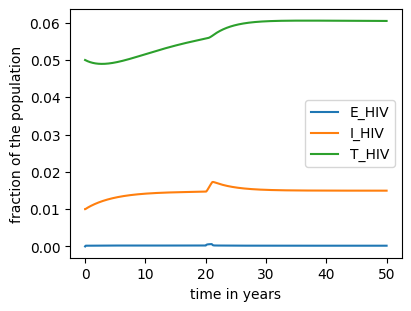

In [48]:
plt.figure(figsize=(4, 3), layout="constrained")
plt.plot(ts / 360.0, output["E_HIV"], label="E_HIV")
plt.plot(ts / 360.0, output["I_HIV"], label="I_HIV")
plt.plot(ts / 360.0, output["T_HIV"], label="T_HIV")
plt.xlabel("time in years")
plt.ylabel("fraction of the population")
plt.legend()

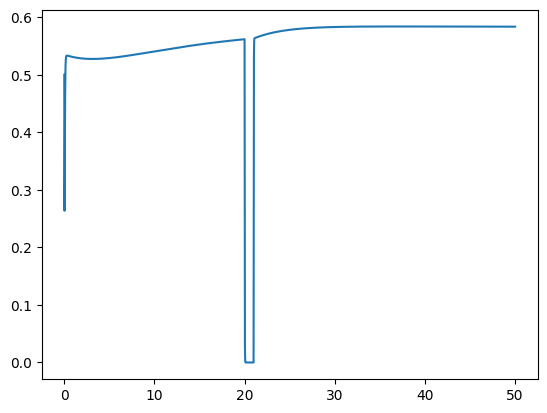

In [49]:
plt.plot(ts / 360.0, output["P_HIV"])

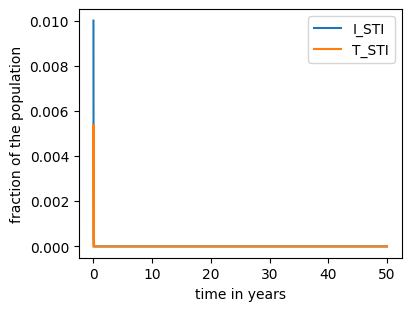

In [50]:
plt.figure(figsize=(4, 3), layout="constrained")
plt.plot(ts / 360.0, output["I_STI"], label="I_STI")
plt.plot(ts / 360.0, output["T_STI"], label="T_STI")


# plt.plot(ts/360., 470*(args["lambda_0"]+ 0*(1-output["P_HIV"]) + args["lambda_P"]*output["P_HIV"])*output["I_STI"] )


plt.xlabel("time in years")


plt.ylabel("fraction of the population")


plt.legend()

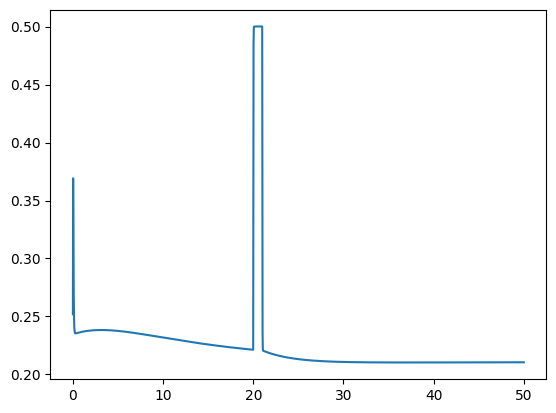

In [52]:
plt.plot(
    ts / 360.0,
    (
        args["lambda_0"]
        + 0.5 * (1 - output["P_HIV"])
        + args["lambda_P"] * output["P_HIV"]
    ),
)  # *output["I_STI"] )

In [19]:
# old tests

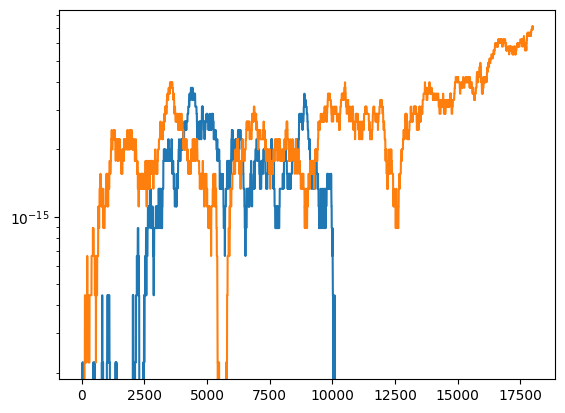

In [20]:
plt.plot(
    ts,
    output["S_HIV"]
    + output["E_HIV"]
    + output["I_HIV"]
    + output["T_HIV"]
    + output["P_HIV"]
    - 1,
)


plt.plot(ts, output["S_STI"] + output["I_STI"] + output["T_STI"] - 1)


plt.yscale("log")

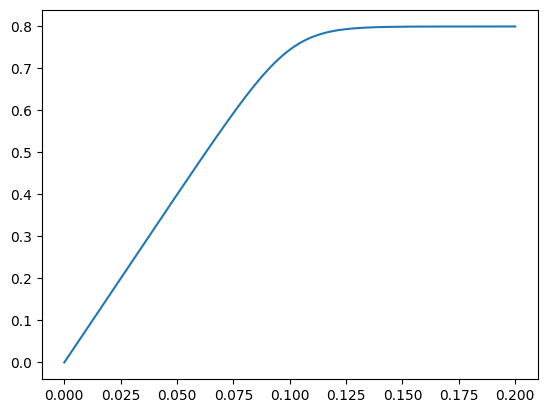

In [21]:
def f(H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


x = np.linspace(0, 0.2, 1000)
plt.plot(x, f(x))

Text(0, 0.5, 'Phi_H')

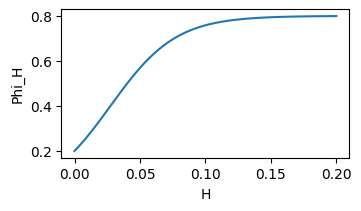

In [22]:
def g(H):
    return (args["Phi_min"] * args["Phi_max"] * jax.numpy.exp(args["Phi_r"] * H)) / (
        args["Phi_min"] * (jax.numpy.exp(args["Phi_r"] * H) - 1) + args["Phi_max"]
    )


x = np.linspace(0, 0.2, 1000)

plt.figure(figsize=(3.5, 2), layout="constrained")
plt.plot(x, g(x))
plt.xlabel("H")
plt.ylabel("Phi_H")